In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
import statsmodels.api as sm
from start_script import *
from arima_script import *
from garch_script import *
from appliances_script import *
from baseline_script import *
import itertools

%matplotlib inline

/usr/local/lib/python3.5/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
plt.rc('figure', figsize=(18.0, 6.0))

In [3]:
pd.set_option('display.max_columns', None) 

In [4]:
df = load_building(545, '2016-7-01 00:00:00', '2016-10-31 00:00:00')

In [5]:
df_weather_austin = load_weather('austin')

### Load data for Building 545

In [6]:
start_trainx, end_trainx, start_testx, end_testx = find_dates(545, 10, 120)
df_trainx, df_testx = create_train_test(df, start_trainx, end_trainx, start_testx, end_testx, 240)

In [6]:
df_trainx, exogenous, endogenous = create_exog_endo(df, df_weather_austin, 545, 10, 120)

In [48]:
# pickle.dump(df_trainx, open('Dash/sarimax_30.p', 'wb'))

In [7]:
df_trainx = pickle.load(open('Dash/sarimax_30.p', 'rb'))

### Fit SARIMAX model

In [20]:
arima_exog_results = fit_exog_arima(exogenous, endogenous)

/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

In [ ]:
mse, rmse = add_forecast(arima_exog_results, df_testx, df_trainx, start_test, end_test)

In [34]:
mse, rmse

(0.53617296606795883, 0.73223832600319338)

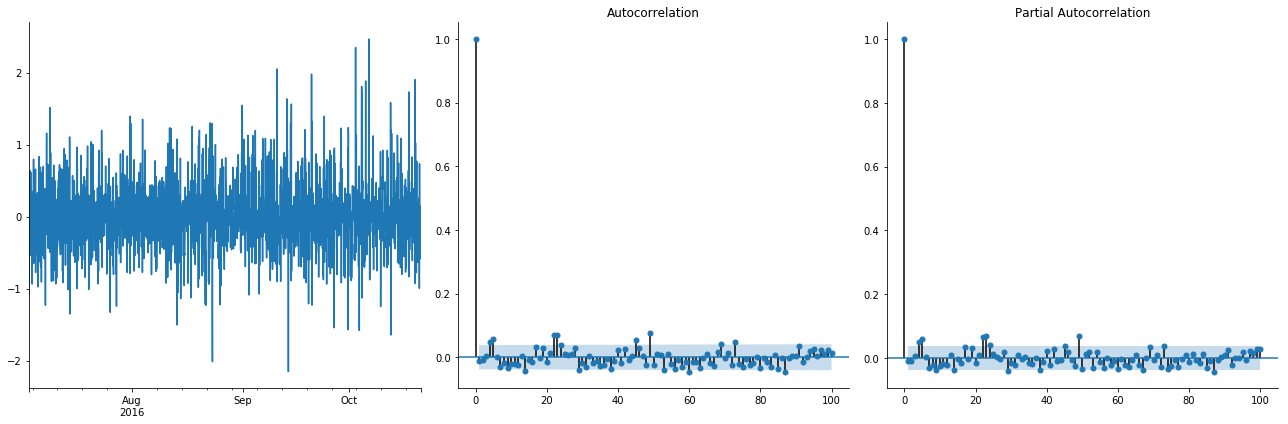

In [35]:
acf_pacf_plots(arima_exog_results.resid.dropna(), lags=100)

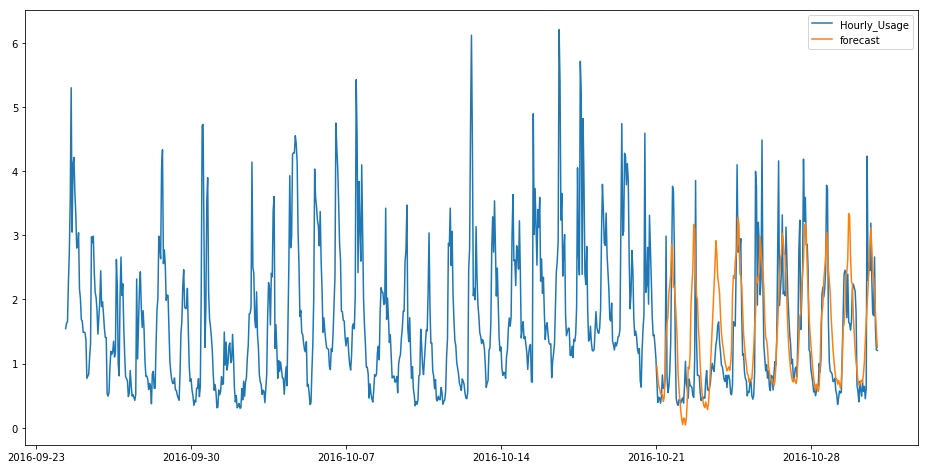

In [36]:
plot_forecast(df_trainx, 2000)

In [8]:
#calculate energy cost based on Austin Energy rates
def calculate_energy_cost(usage):
    
    total_cost = 0
    if usage < 501:
        total_cost += usage*0.02801
    elif usage < 1001:
        total_cost += (usage-500)*0.05832 + 500*0.02801
    elif usage < 1501:
        total_cost += (usage-1000)*0.07814 + 500*0.05832 + 500*0.02801
    elif usage < 2500:
        total_cost += (usage-1500)*0.09314 + 500*0.07814 + 500*0.05832 + 500*0.02801
    else:
        total_cost += (usage-2500)*0.10814 + 1000*0.09314 + 500*0.7814 + 500*0.05832 + 500*0.02801
    
    total_cost+= 10+ usage*(0.02727+0.00172+0.00138+0.00251+0.01343)
    
    return total_cost

### Create Dash App

In [9]:
import dash
from dash.dependencies import Input, Output
import dash_core_components as dcc
import dash_html_components as html
import base64

In [10]:
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.dashboard_objs as dashboard
import IPython.display
from IPython.display import Image

In [36]:
colors = {
    'background_page': '#B7F4C5',
    'background_plot': '#F0F3F0',
    'blue': 'rgb(44, 112, 246)',
    'green': 'rgb(41, 186, 55)',
    'text': '#122116'
}

Calculate appliance usage for building and neighborhood

In [116]:
average_appliances = pickle.load(open('pickle_files/average_appliance.p', 'rb'))
df_545 = pickle.load(open('pickle_files/df_545.p', 'rb'))
df_545.index = df_545.apply(strip_tz, axis=1)

In [118]:
average_appliances['Air'] = average_appliances.pop('air1')
average_appliances['Bedroom'] = average_appliances.pop('bedroom1')
average_appliances['Car'] = average_appliances.pop('car1')
average_appliances['Dishwasher'] = average_appliances.pop('dishwasher1')
average_appliances['Dryer'] = average_appliances.pop('dryg1')
average_appliances['Furnace'] = average_appliances.pop('furnace1')
average_appliances['Living Room'] = average_appliances.pop('livingroom1')
average_appliances['Microwave'] = average_appliances.pop('microwave1')
average_appliances['Refrigerator'] = average_appliances.pop('refrigerator1')

In [112]:
appliances = ['air1','bedroom1','car1','dishwasher1','dryg1','furnace1','livingroom1','microwave1','refrigerator1']
appliances_545 = monthly_usage(545,appliances)

In [113]:
total_appliances_545 = {}
for appliance in appliances_545.keys():
    total_appliances_545[appliance]= sum(appliances_545[appliance].values)

In [114]:
total_appliances_545['Air'] = total_appliances_545.pop('air1')
total_appliances_545['Bedroom'] = total_appliances_545.pop('bedroom1')
total_appliances_545['Car'] = total_appliances_545.pop('car1')
total_appliances_545['Dishwasher'] = total_appliances_545.pop('dishwasher1')
total_appliances_545['Dryer'] = total_appliances_545.pop('dryg1')
total_appliances_545['Furnace'] = total_appliances_545.pop('furnace1')
total_appliances_545['Living Room'] = total_appliances_545.pop('livingroom1')
total_appliances_545['Microwave'] = total_appliances_545.pop('microwave1')
total_appliances_545['Refrigerator'] = total_appliances_545.pop('refrigerator1')

Images for initial segments

In [103]:
image_co2 = 'CO2.png' 
encoded_image_co2 = base64.b64encode(open(image_co2, 'rb').read())

image_tree = 'Tree.png'
encoded_image_tree = base64.b64encode(open(image_tree, 'rb').read())

image_led = 'LED.png'
encoded_image_led = base64.b64encode(open(image_led, 'rb').read())

image_down = 'Down_Arrow.png'
encoded_image_down = base64.b64encode(open(image_down, 'rb').read())

image_up = 'Up_Arrow.png'
encoded_image_up = base64.b64encode(open(image_up, 'rb').read())

Numbers for initial segments

In [104]:
predicted_month= 1015.9825
actual_month = 1182.019

input_1 = calculate_energy_cost(actual_month)
input_2 = calculate_energy_cost(predicted_month)
input_3 = (actual_month/predicted_month - 1)*100
input_4 = 7.44E-4 * actual_month
input_5 = input_4/ 0.039
input_6 = input_4/2.99E-2

Dropdown menu

In [119]:
available_appliances = []
available_appliances.append('Select Appliance')
available_appliances.extend([x for x in total_appliances_545.keys()])

In [120]:
available_appliances

['Select Appliance',
 'Refrigerator',
 'Car',
 'Air',
 'Living Room',
 'Furnace',
 'Dishwasher',
 'Dryer',
 'Bedroom',
 'Microwave']

In [121]:
app = dash.Dash()

In [122]:
app.layout = html.Div([
    html.H1('Welcome Kevin!',
           style={'textAlign': 'center','line-height':'100px','color': colors['text'],'font-family':'"Arial Black", Gadget, sans-serif',
               'font-size':'4.0rem','backgroundColor':colors['background_page'],'border-radius':'25px'
           },className='eight columns'  
    ),
    
    #Row 1
    
    html.Div([ 
        
        html.Div([
                html.H3('This Month:', style={'font-size':'1.5rem', 'font-family':'Tahoma, Geneva, sans-serif'}),
                html.H1('${}'.format(round(input_1,2)),style={'font-size':'3rem', 'font-family': 'Impact, Charcoal, sans-serif'}),
                html.H1('{} kWh'.format(round(actual_month,2)),style={'font-size':'2.5rem','font-family': 'Impact, Charcoal, sans-serif'})
            ], className='four columns',style={'textAlign':'center', 'float':'left', 'height':'300', 'width':'32%',
                                               'border-radius':'25px','backgroundColor':colors['background_plot'],
                                              'border-style':'solid', 'border-color':colors['blue']}),
           
        html.Div([
                html.H3('Next 30 Days Projection:', style={'font-size':'1.5rem', 'font-family':'Tahoma, Geneva, sans-serif'}),
                html.H1('${}'.format(round(input_2,2)),style={'font-size':'3rem', 'font-family': 'Impact, Charcoal, sans-serif'}),
                html.H1('{} kWh'.format(round(predicted_month,2)),style={'font-size':'2.5rem', 'font-family': 'Impact, Charcoal, sans-serif'})
            ], className='four columns', style={'textAlign':'center', 'float':'left', 'height':'300', 'width':'32%',
                                                'border-radius':'25px','backgroundColor':colors['background_plot'],
                                               'border-style':'solid', 'border-color':colors['blue']}),
    
        html.Div([
                html.H3('Comparison to Neighborhood:', style={'font-size':'1.5rem', 'font-family':'Tahoma, Geneva, sans-serif'}),
                html.H1('{}% Higher'.format(round(input_3,1)),style={'font-size':'3rem', 'font-family': 'Impact, Charcoal, sans-serif'}),
                html.Img(src='data:image/png;base64,{}'.format(encoded_image_up.decode()), style={'height':'100', 'width':'40%'})
            ], className='four columns', style={'textAlign':'center', 'float':'left', 'height':'300', 'width':'32%',
                                                'border-radius':'25px','backgroundColor':colors['background_plot'],
                                               'border-style':'solid', 'border-color':colors['blue']})
        
    ], className='row', style={}),
    
    
    #Row 2
    html.Div([ 
        
        html.Div([
                html.H3('{} Metric Tons'.format(round(input_4,1)),style={'color': colors['text'],'font-family': 'Impact, Charcoal, sans-serif',
                        'font-size': '2.5rem','font-color': '#7f7f7f'}),
                html.Img(src='data:image/png;base64,{}'.format(encoded_image_co2.decode()), style={'height':'150', 'width':'80%'})], 
                    className='four columns',style={'textAlign':'center', 'float':'left', 'height':'300', 'width':'32%',
                                               'border-radius':'25px','backgroundColor':colors['background_plot'],
                                                   'border-style':'solid', 'border-color':colors['green']}),
           
        html.Div([
                html.H3('{} Trees to Grow'.format(int(input_5)),style={'color': colors['text'],'font-family': 'Impact, Charcoal, sans-serif',
                        'font-size': '2.5rem','font-color': '#7f7f7f'}),
                html.Img(src='data:image/png;base64,{}'.format(encoded_image_tree.decode()),style={'height':'150', 'width':'60%'})], 
                    className='four columns',style={'textAlign':'center', 'float':'left', 'height':'300', 'width':'32%',
                                               'border-radius':'25px','backgroundColor':colors['background_plot'],
                                                   'border-style':'solid', 'border-color':colors['green']}),
    
        html.Div([
                html.H3('Switch to {} LED Lightbulbs'.format(int(input_6)),style={'color': colors['text'],'font-family': 'Impact, Charcoal, sans-serif',
                        'font-size': '2.2rem','font-color': '#7f7f7f'}),
                html.Img(src='data:image/png;base64,{}'.format(encoded_image_led.decode()),style={'height':'180', 'width':'60%'})], 
                    className='four columns',style={'textAlign':'center', 'float':'left', 'height':'300', 'width':'32%',
                                               'border-radius':'25px','backgroundColor':colors['background_plot'],
                                                   'border-style': 'solid', 'border-color':colors['green']})
        
    ], className='row', style={'position':'relative', 'left':'0', 'top':'0'}),
    

    # Row 3

    html.Div([

        html.H3('Energy Consumption & Forecast',
            style={
                'textAlign': 'center',
                'color': colors['text'],
                'font-family': 'Impact, Charcoal, sans-serif',
                'font-size': '3rem',
                'font-color': '#7f7f7f'
            }),
        
        dcc.Graph(
            id='sarimax_30days',
            figure={
                'data': [
                    {'x': df_trainx.loc[start_trainx:start_testx,:].index, 
                     'y': df_trainx.loc[start_trainx:start_testx,'Hourly_Usage'], 'type': 'scatter', 'name': 'Hourly Usage',
                     'line': dict(color=colors['green']),'fill': 'tozeroy'
                    },
                    {'x': df_trainx.loc[start_trainx:end_testx,:].index, 
                     'y': df_trainx.loc[start_trainx:end_testx,'forecast'], 'type': 'scatter', 'name': 'Forecast',
                    'line': dict(color=colors['blue']),'fill': 'tozeroy'
                    }
                ],
                'layout': {
                    'font': dict(family='Courier New, monospace', size=14, color='#7f7f7f'),
                    'yaxis': dict(
                        title='Energy Consumption (kWh)',
                        titlefont=dict(
                            family='Courier New, monospace', size=18, color='#7f7f7f')),
                    'plot_bgcolor': colors['background_plot'],
                    'paper_bgcolor': colors['background_plot']
                }
            }
        )
    ], className='row', style={'position':'relative', 'left':'0', 'top':'30'}),
    
    
    
    #Row 4
    
    html.Div([
        html.H3('Appliance Usage This Month',
            style={
                'textAlign': 'center',
                'color': colors['text'],
                'font-family': 'Impact, Charcoal, sans-serif',
                'font-size': '3rem',
                'font-color': '#7f7f7f'
            }
        ),
        
        dcc.Graph(
            id='appliances_month',
            figure={
                'data': [
                    {
                        'x': [x for x in total_appliances_545.keys()],
                        'y': [y for y in total_appliances_545.values()], 'type': 'bar', 'name': 'Your Home',
                        'marker':dict(
                        color=colors['blue'],
                        line=dict(
                            color=colors['blue'],
                            width=1.5)
            )
                    },
                    {
                        'x': [x for x in average_appliances.keys()],
                        'y': [y for y in average_appliances.values()], 'type': 'bar', 'name': 'Your Neighborhood',
                        'marker':dict(
                        color=colors['green'],
                        line=dict(
                            color=colors['green'],
                            width=1.5)
            )
                    }
                ],
                'layout': {
                    'plot_bgcolor': colors['background_plot'],
                    'paper_bgcolor': colors['background_plot'],
                    'xaxis': dict(
                        title='Appliance',
                        titlefont=dict(
                            family='Courier New, monospace', size=18, color='#7f7f7f'),
                        tickfont=dict(
                            family='Courier New, monospace', size=16)),
                    'yaxis': dict(
                        title='Energy Consumption (kWh)',
                        titlefont=dict(
                            family='Courier New, monospace', size=18, color='#7f7f7f')),
                    'font': dict(family='Courier New, monospace', size=14, color='#7f7f7f')
                }
            }
        )
    ],className='row',style={'position':'relative', 'left':'0', 'top':'0'}),
    
    #Row 5
    
    html.Div([
        html.Div([
            dcc.Dropdown(
                id='select_appliance',
                options=[{'label': i, 'value': i} for i in available_appliances],
                value='Select Appliance')],
            style={'width': '48%', 'display': 'inline-block'}),
        dcc.Graph(id='appliance_plot')   
    ], className='row', style={'position':'relative', 'left':'0', 'top':'0'})
    
    
])


In [123]:
@app.callback(
    dash.dependencies.Output('appliance_plot', 'figure'),
    [dash.dependencies.Input('select_appliance', 'value')])
def update_appliances(select_appliance):
    appliance_dict = {'Air':'air1','Bedroom':'bedroom1', 'Car':'car1','Dishwasher':'dishwasher1',
                  'Dryer':'dryg1','Furnace':'furnace1','Living Room':'livingroom1',
                  'Microwave':'microwave1','Refrigerator':'refrigerator1'}
    data = []
        
    data.append(go.Scatter(
            x = df_545.loc[start_trainx:end_trainx, :].index,
            y = df_545.loc[start_trainx:end_trainx, appliance_dict[select_appliance]],
            marker={'color':colors['blue'],
                    'line':{'color':colors['blue'], 'width': '1.5'}
            }))
    layout = {
                'plot_bgcolor': colors['background_plot'],
                'paper_bgcolor': colors['background_plot'],
                'xaxis': dict(
                    tickfont=dict(
                        family='Courier New, monospace', size=16)),
                'yaxis': dict(
                    title='Energy Consumption (kWh)',
                    titlefont=dict(
                        family='Courier New, monospace', size=18, color='#7f7f7f')),
                'font': dict(family='Courier New, monospace', size=14, color='#7f7f7f'),
                'marker':dict(
                        color=colors['green'],
                        line=dict(
                            color=colors['green'],
                            width=1.5))
            }
    
    return {
                'data': data,
                'layout': layout
            }
    

In [ ]:
if __name__ == '__main__':
    app.run_server(host='ec2-54-85-160-56.compute-1.amazonaws.com', debug = False)
    

 * Running on http://ec2-54-85-160-56.compute-1.amazonaws.com:8050/ (Press CTRL+C to quit)
38.140.126.106 - - [21/Sep/2017 01:26:21] "GET / HTTP/1.1" 200 -
38.140.126.106 - - [21/Sep/2017 01:26:22] "GET /_dash-layout HTTP/1.1" 200 -
38.140.126.106 - - [21/Sep/2017 01:26:22] "GET /_dash-dependencies HTTP/1.1" 200 -
38.140.126.106 - - [21/Sep/2017 01:26:22] "GET /favicon.ico HTTP/1.1" 200 -
[2017-09-21 01:26:22,574] ERROR in app: Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/flask/app.py", line 1982, in wsgi_app
    response = self.full_dispatch_request()
  File "/usr/local/lib/python3.5/dist-packages/flask/app.py", line 1614, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/usr/local/lib/python3.5/dist-packages/flask/app.py", line 1517, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/usr/local/lib/python3.5/dist-packages/flask/_compat.py", line 33, in reraise
  